<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
!pip install catboost --no-cache-dir

In [ ]:
!pip install lightgbm

In [ ]:
import pandas as pd #импортируем Pandas
import numpy as np# импортируем Numpy
import matplotlib.pyplot as plt #импортирем для графиков 
from sklearn.model_selection import train_test_split #для разделения выборки
from statsmodels.tsa.stattools import adfuller #для Dickey-Fuller test 
from statsmodels.tsa.seasonal import seasonal_decompose #для трендов и сезонности
from sklearn.model_selection import TimeSeriesSplit #для разделения данных временных рядов
from sklearn.linear_model import LinearRegression #линейная регрессия
from sklearn.ensemble import RandomForestRegressor #случайный лес
from sklearn.model_selection import GridSearchCV #оптимальные параметры
from catboost import CatBoostRegressor, Pool # CatBoostRegressor
from lightgbm import LGBMRegressor as lbm # для Lightgbm
from sklearn.metrics import mean_squared_error #для MSE

In [ ]:
data = pd.read_csv("taxi.csv", index_col = [0], parse_dates = [0]) #скачаем файл, назначим столбец с датой за индексы
data.head() #выведем 5 верхних строк

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [ ]:
data.sort_index(inplace = True)#сортируем по возрастанию индексы

Теперь перейдем к ресемблированию временного ряда, в нашем случае - это один час.

In [ ]:
data = data.resample('1H').sum() #суммируем значения за каждый час

In [ ]:
data.head(3) #проверка на ресемблирование

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71

Таким образом, мы провели загрузку и подготовку данных, провели ресемблирование за один час. Перейдем к анализу данных.

## Анализ

<AxesSubplot:xlabel='datetime'>

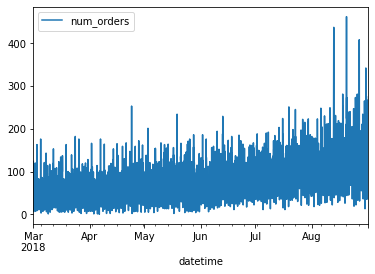

In [ ]:
data.plot() #отобразим график, кстати не могу вспомнить как его расширить в длинну?:D

In [ ]:
#скопирую, чтобы непосредственно добавить некоторые столбы в другую переменную, а потом не удалять эти же столбы
data_1 =  data.copy() 

In [ ]:
data_1["rolling_mean"] =  data_1["num_orders"].rolling(7).mean() #скользящее среднее отклонение
data_1["rolling_std"] =  data_1["num_orders"].rolling(7).std() #скользящее стандартное отклонение

<AxesSubplot:xlabel='datetime'>

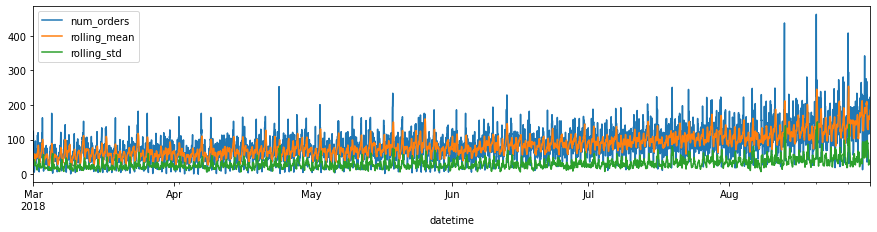

In [ ]:
plt.figure(figsize = (15,11))
plt.subplot(311)
data_1.plot(ax=plt.gca()) #график 

<AxesSubplot:xlabel='datetime'>

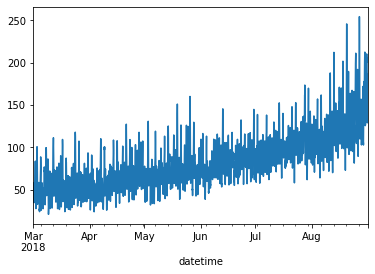

In [ ]:
data_1["rolling_mean"].plot(ax=plt.gca()) #график скользящего среднего

Скользящее среднеее стационарно.

<AxesSubplot:xlabel='datetime'>

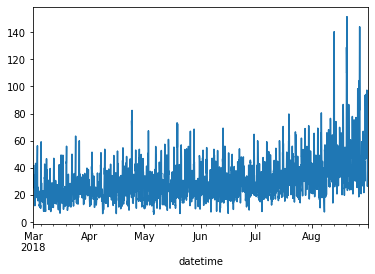

In [ ]:
data_1["rolling_std"].plot(ax=plt.gca()) #график скользящего стандартного

Скальзящее стандартное отклонение стационарно.

<AxesSubplot:xlabel='datetime'>

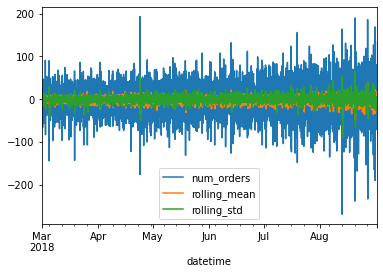

In [ ]:
(data_1 - data_1.shift()).plot(ax=plt.gca()) #разности временного ряда

Тут наиболее визуально можно увидеть, что cкользящее среднее и скользящее стандартное не меняется, следовательно, временной ряд является стационарным. Попробуем подтвердить предположение тестом Дикки Фуллера.

In [ ]:
adfuller(data) #тест Дикки Фуллер

(-3.0689242890279482,
 0.028940051402613506,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

h_0 - ряд не стационарный
h_1 - ряд стационарный

Так как, при квантиле 5% p.value = 0.02 > - 2.86, следовательно нулевую гипотезу отвергаем, ряд является стационарным.

Посмотрим на тренд и сезонность в какой-либо промежуток времени.

In [ ]:
 data.index # индексы

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               ...
               '2018-08-31 14:00:00', '2018-08-31 15:00:00',
               '2018-08-31 16:00:00', '2018-08-31 17:00:00',
               '2018-08-31 18:00:00', '2018-08-31 19:00:00',
               '2018-08-31 20:00:00', '2018-08-31 21:00:00',
               '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=4416, freq='H')

In [ ]:
decomposed = seasonal_decompose(data) #сохраняем в переменную параметры

<AxesSubplot:title={'center':'сезонность за неделю'}, xlabel='datetime'>

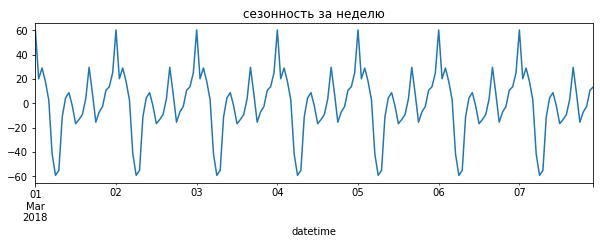

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("сезонность за неделю")
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-07 22:00:00'].plot(ax=plt.gca())

<AxesSubplot:title={'center':'сезонность по часам'}, xlabel='datetime'>

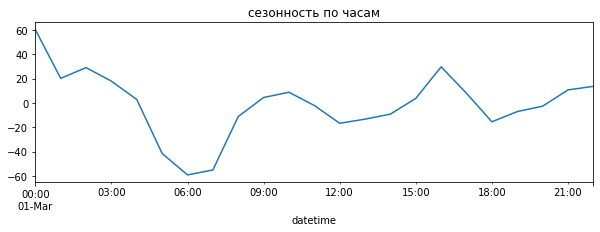

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("сезонность по часам")
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-01 22:00:00'].plot(ax=plt.gca())

<AxesSubplot:title={'center':'тренд по всему датасету'}, xlabel='datetime'>

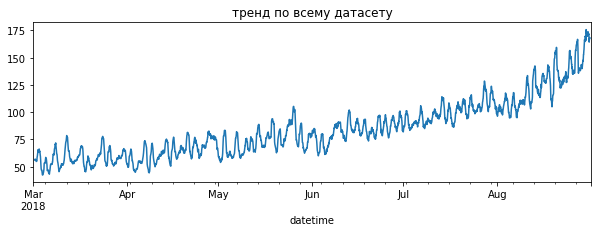

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("тренд по всему датасету")
decomposed.trend.plot(ax=plt.gca())

<AxesSubplot:title={'center':'тренд по дням'}, xlabel='datetime'>

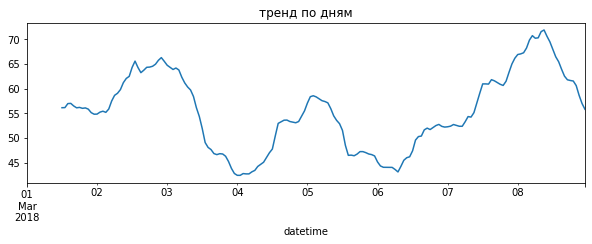

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("тренд по дням")
decomposed.trend['2018-03-01':'2018-03-08'].plot(ax=plt.gca())

<AxesSubplot:title={'center':'тренд за первую неделю марта'}, xlabel='datetime'>

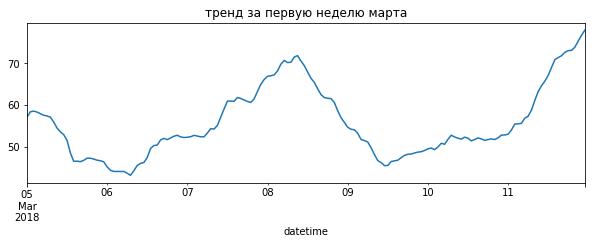

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("тренд за первую неделю марта")
decomposed.trend["2018-03-05":"2018-03-11"].plot(ax=plt.gca())

Вниманание! Эта неделя отображает тот момент, что 8,9 марта это выходные, следовательно отгуляв выходные люди были дома)

<AxesSubplot:title={'center':'тренд за первую неделю марта'}, xlabel='datetime'>

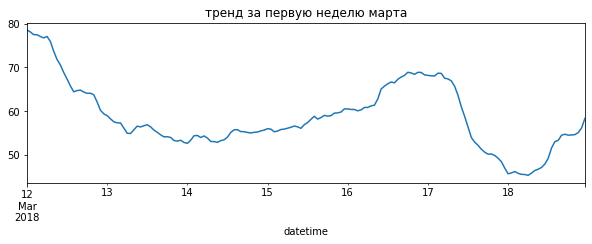

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("тренд за первую неделю марта")
decomposed.trend["2018-03-12":"2018-03-18"].plot(ax=plt.gca())

Отдохнув после праздников все побежали работать.

<AxesSubplot:title={'center':'тренд за третью неделю марта'}, xlabel='datetime'>

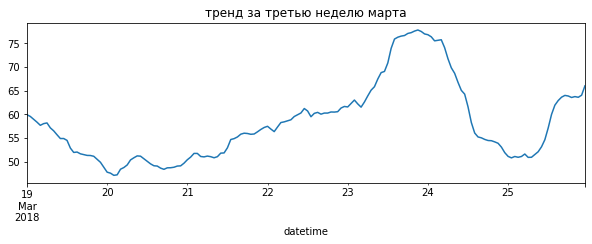

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("тренд за третью неделю марта")
decomposed.trend["2018-03-19":"2018-03-25"].plot(ax=plt.gca())

Взяв тренд за 3 недели марта, можно сделать вывод что ситуауия примерно одинакова, в понедельник спрос на такси средний, ко ко вторнику он уменьшается, пятница, суббота - пики заказов на такси, показатели в среднем выше, чем в буднии дни. Рассмотрим сезонность. 


<AxesSubplot:title={'center':'Сезонность за первую неделю марта'}, xlabel='datetime'>

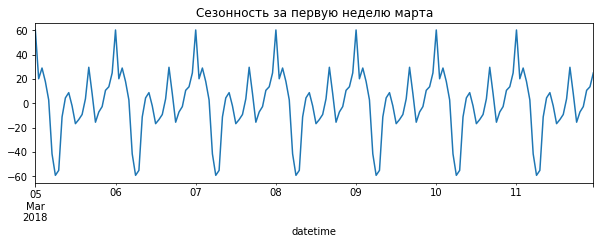

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("Сезонность за первую неделю марта")
decomposed.seasonal["2018-03-05":"2018-03-11"].plot(ax=plt.gca())

<AxesSubplot:title={'center':'Сезонность за вторую неделю марта'}, xlabel='datetime'>

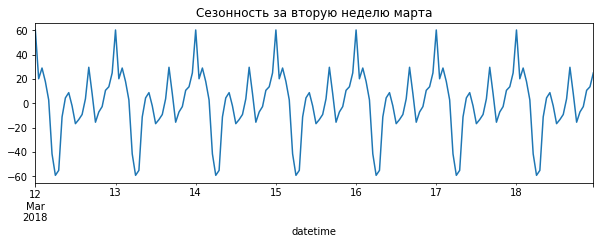

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("Сезонность за вторую неделю марта")
decomposed.seasonal["2018-03-12":"2018-03-18"].plot(ax=plt.gca())

<AxesSubplot:title={'center':'Сезонность за третью неделю марта'}, xlabel='datetime'>

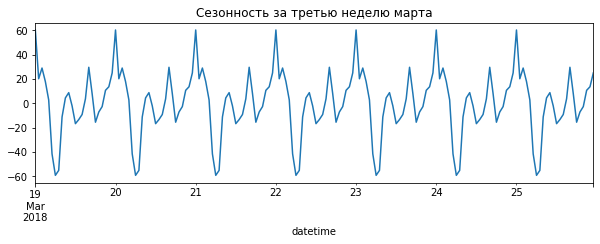

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title("Сезонность за третью неделю марта")
decomposed.seasonal["2018-03-19":"2018-03-25"].plot(ax=plt.gca())

Сезонность аналогична, в начале дня количество заказов высокое, постепенно к обеду оно падает и увеличивается к вечеру. Итак циклично каждый день.

Таким образом, мы провели анализ исходных данных, провели анализ сезонности, трендов, провели проверку на стационарность.

## Обучение

Прежде чем перейти к обучению моделей регрессии предлагаю поработать над признаками.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data["hour"] = data.index.hour #признак часа
    data['dayofweek'] = data.index.dayofweek #для недели
    
    for lag in range(1, max_lag + 1): #создааем отстающие значения 
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling_mean_size).mean() #скользящее среднее

In [ ]:
make_features(data, 24, 20) #24 часа как параметр lag, ширина окна 10

In [ ]:
train, test = train_test_split(data, shuffle = False, test_size = 0.1) #делим выборку на тренировочную и тестовую

In [ ]:
train = train.dropna()

In [ ]:
features_train = train.drop("num_orders", axis = 1)
target_train = train["num_orders"]

features_test = test.drop("num_orders", axis = 1)
target_test = test["num_orders"]

In [ ]:
print(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(3950, 27) (3950,) (442, 27) (442,)


Перейдем к обучению на различных моделях, чтобы подобрать оптимальные параметры и не обучать модель на данных из будущего введем параметр.

In [ ]:
tscv = TimeSeriesSplit(n_splits = 8)

### RandomForest

In [ ]:
%%time
model = RandomForestRegressor(random_state = 12345) #создали
params = { "max_depth" : [2,3], "n_estimators" : [100, 200]} #параметры
model_rf = GridSearchCV(model, params, cv = tscv) #перебираем параметры
model_rf.fit(features_train, target_train) #обучили
model_rf.best_params_

CPU times: total: 10.3 s
Wall time: 10.3 s


{'max_depth': 3, 'n_estimators': 100}

### CatBoost

In [ ]:
%%time
catboost = CatBoostRegressor(random_state = 12345)
params = {'learning_rate': [0.05, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]} #создаем массив с параметрами
catboost_grid = catboost.grid_search(params,
            Pool(features_train,target_train),cv=tscv,verbose=True)

0:	learn: 75.9959068	test: 111.3695216	best: 111.3695216 (0)	total: 191ms	remaining: 3m 10s
1:	learn: 72.7372316	test: 107.6251637	best: 107.6251637 (1)	total: 195ms	remaining: 1m 37s
2:	learn: 69.6526083	test: 104.0601481	best: 104.0601481 (2)	total: 199ms	remaining: 1m 6s
3:	learn: 66.8470298	test: 100.5915000	best: 100.5915000 (3)	total: 203ms	remaining: 50.5s
4:	learn: 64.1909882	test: 97.6111409	best: 97.6111409 (4)	total: 207ms	remaining: 41.1s
5:	learn: 61.6101318	test: 94.6160818	best: 94.6160818 (5)	total: 211ms	remaining: 35s
6:	learn: 59.1587358	test: 91.8137160	best: 91.8137160 (6)	total: 215ms	remaining: 30.4s
7:	learn: 56.8670413	test: 89.2014780	best: 89.2014780 (7)	total: 219ms	remaining: 27.1s
8:	learn: 54.6907120	test: 86.5026138	best: 86.5026138 (8)	total: 223ms	remaining: 24.5s
9:	learn: 52.7064723	test: 84.0795558	best: 84.0795558 (9)	total: 225ms	remaining: 22.3s
10:	learn: 50.7871181	test: 81.6783190	best: 81.6783190 (10)	total: 227ms	remaining: 20.4s
11:	learn: 

In [ ]:
catboost_grid

{'params': {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

In [ ]:
%%time
catboost_best = CatBoostRegressor(depth = 6, l2_leaf_reg = 5, learning_rate = 0.1)
catboost_best.fit(features_train, target_train)

0:	learn: 36.9650488	total: 3.95ms	remaining: 3.95s
1:	learn: 35.4715426	total: 7.68ms	remaining: 3.83s
2:	learn: 34.0500153	total: 11.5ms	remaining: 3.81s
3:	learn: 32.8325470	total: 15.2ms	remaining: 3.78s
4:	learn: 31.7630999	total: 18.7ms	remaining: 3.72s
5:	learn: 30.7825505	total: 22.4ms	remaining: 3.71s
6:	learn: 30.0279878	total: 25.9ms	remaining: 3.68s
7:	learn: 29.2951289	total: 29.6ms	remaining: 3.67s
8:	learn: 28.5888646	total: 33.3ms	remaining: 3.67s
9:	learn: 27.9653177	total: 37ms	remaining: 3.66s
10:	learn: 27.4571740	total: 40.8ms	remaining: 3.67s
11:	learn: 26.9923832	total: 44.9ms	remaining: 3.69s
12:	learn: 26.5576759	total: 48.7ms	remaining: 3.7s
13:	learn: 26.2174035	total: 52.5ms	remaining: 3.7s
14:	learn: 25.9302244	total: 56.9ms	remaining: 3.73s
15:	learn: 25.6313983	total: 61.9ms	remaining: 3.81s
16:	learn: 25.3350589	total: 68.1ms	remaining: 3.94s
17:	learn: 25.1033726	total: 71.9ms	remaining: 3.92s
18:	learn: 24.8779968	total: 76.3ms	remaining: 3.94s
19:	lea

### LightGBM

In [ ]:
model = lbm(random_state = 12345)
params = {'metric': ['neg_mean_squared_error'], 'max_depth': [5] ,"learning_rate": [0.1, 0,2]} #аналогично
lgb_best = GridSearchCV(model, params, cv = tscv) #аналогично

In [ ]:
%%time 
lgb_best.fit(features_train, target_train) #обучили

CPU times: total: 3.33 s
Wall time: 677 ms


C:\Users\oleg\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\oleg\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\oleg\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\oleg\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\oleg\anaconda3\lib\

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.1, 0, 2], 'max_depth': [5],
                         'metric': ['neg_mean_squared_error']})

## Тестирование

In [ ]:
%%time
predict_y_1 = model_rf.predict(features_test)
print("Значение RMSE для RandomForest составляет:", mean_squared_error(target_test, predict_y_1, squared = False))

Значение RMSE для RandomForest составляет: 58.77975090184326
CPU times: total: 15.6 ms
Wall time: 19.6 ms


In [ ]:
%%time
predict_y_2 = catboost_best.predict(features_test)
print("Значение RMSE для catboost составляет:", mean_squared_error(target_test, predict_y_2, squared = False))

Значение RMSE для catboost составляет: 41.388091584948704
CPU times: total: 31.2 ms
Wall time: 52.4 ms


In [ ]:
%%time
predict_y_3 = lgb_best.predict(features_test)
print("Значение RMSE для LightGBM составляет:", mean_squared_error(target_test, predict_y_3, squared = False))

Значение RMSE для LightGBM составляет: 41.2953398301331
CPU times: total: 0 ns
Wall time: 11.9 ms


In [ ]:
table = pd.DataFrame({"name":["RandomForest", "CatBoostRegressor", "LightGBM"],
                     "Время обучения" : ["10.8s", "16.4s", "731ms"],
                     "Время предсказания" : ["32.7", "5 ms", "8.23 ms"],
                     "RMSE" : ["58.7","41.38","41.29"]})
table

Таким образом, в рамках нашей задачи нам удалось обучить 3 модели, 2 из которых показали результаты, удовлетворяющие условиям поставленной задачи. LightGBM модель показала лучший результат, лишь немного превосходящий CatBoostRegressor.

[]

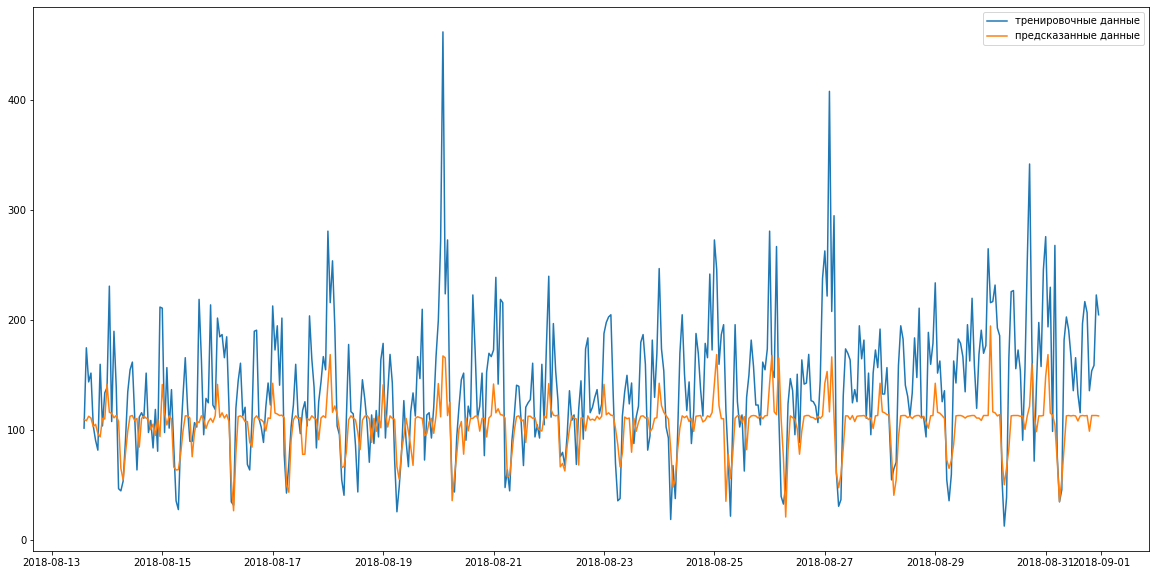

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(features_test.index, target_test, label = "тренировочные данные")
plt.plot(features_test.index, predict_y_1, label = "предсказанные данные")
plt.legend()
plt.plot()